# Cancer Cell Detection
> Classify image patches as normal or malignant in the Histopathologic Cancer dataset

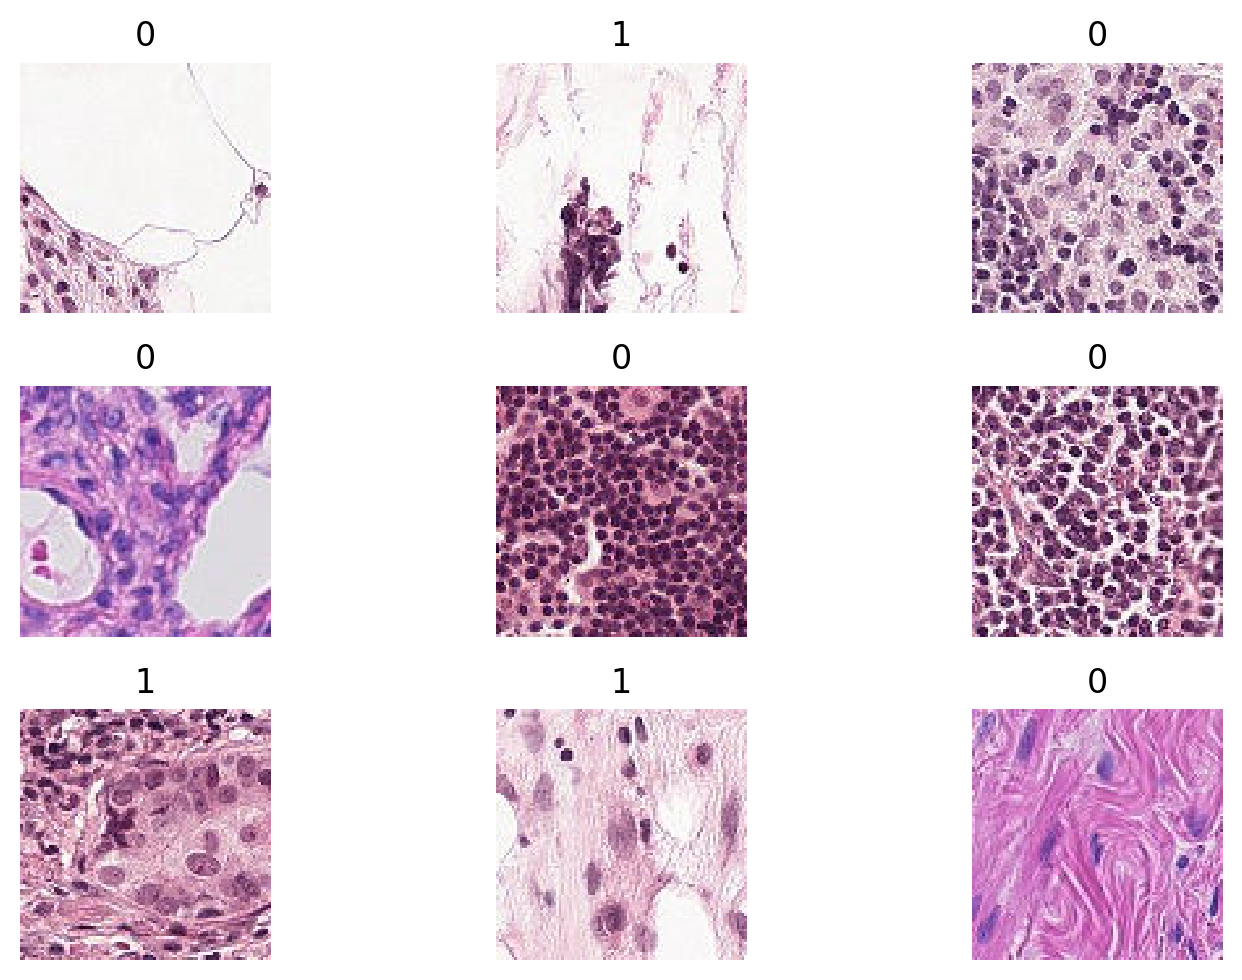

### Objective

Classify image patches as normal or malignant in the Histopathologic Cancer dataset?

### Acquire the data

https://www.kaggle.com/c/histopathologic-cancer-detection/data.

### Describe the data

The train folder contains 220,025 .tif images that are 96x96 in size. The .tif images are named with an image ID. The train_labels.csv file provides the ground truth for the images in the train folder.

### Prepare the data

A traditional method for working with a dataset would be to load all images into NumPy arrays. Since we are dealing with a relatively large dataset, this would be a waste of our computer resources. If you are short on RAM, this would be impossible. Luckily, PyTorch has a powerful tool to handle large datasets.

We can create a custom Dataset class by subclassing the PyTorch Dataset class. When creating a custom Dataset class, make sure to define two essential functions: **len** and **getitem**. The **len** function returns the dataset's length. This function is callable with the Python len function. The **getitem** function returns an image at the specified index.

We will define a class for the custom dataset, define the transformation function, and then load an image from the dataset using the Dataset class:

In [ ]:
# load the required packages
import os
import pandas as pd
from PIL import image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# fix torch manual seed
torch.manual_seed(0)

# define the histoCancerDataset class
class histoCancerDataset(Dataset):
		def __init__(self, data_dir, transform, data_type="train"):
				# path to images
				path2data = os.path.join(data_dir,data_type)
				# get a list of images
				filenames = os.listdir(path2data)
				# get the full path to images
				self.full_filenames = [os.path.join(path2data, f) for f in filenames]
				# labels are in a csv file named train_labels.csv
				csv_filename = data_type+"_labels.csv"
				path2csvLabels = os.path.join(data_dir,csv_filename)
				labels_df = pd.read_csv(path2csvLabels)
				# set data frame index to id
				labels_df.set_index("id", inplace=True)
				# obtain labels from data frame
				self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
				self.transform = transform
		def __len__(self):
				# return size of dataset
				return len(self.full_filenames)
		def __getitem__(self, idx):
				# open image, apply transforms and return with label
				image = Image.open(self.full_filenames[idx]) # PIL image
				image = self.transform(image)
				return image, self.labels[idx]

Define a simple image transformation pipeline

In [ ]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

Let's load an image from this dataset object

In [ ]:
data_dir = "./data/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))
>> 220025

# load an image
img,label = histo_dataset[9]
print(img.shape,torch.min(img),torch.max(img))
>> torch.Size([3, 96, 96]) tensor(0.) tensor(1.)

We will split the dataset into training and validation and then display a few sample images from each dataset:

In [ ]:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

>> train dataset length: 176020
>> validation dataset length: 44005

# Let's display a few samples from train_ds:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

Let's display a few samples from train_ds:

In [ ]:
# Define a helper function to show an image:
def show(img, y, color=False):
		# convert tensor to numpy array
		npimg = img.numpy()
		# Convert to H*W*C shape
		npimg_tr=np.transpose(npimg, (1,2,0))
		if color==False:
				npimg_tr=npimg_tr[:,:,0]
				plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
		else:
				# display images
				plt.imshow(npimg_tr,interpolation='nearest')
		plt.title("label: "+str(y))

		# Create a grid of sample images:
		grid_size=4
		rnd_inds = np.random.randint(0,len(train_ds),grid_size)
		print("image indices:",rnd_inds)
		x_grid_train=[train_ds[i][0] for i in rnd_inds]
		y_grid_train=[train_ds[i][1] for i in rnd_inds]
		x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
		print(x_grid_train.shape)

# Call the helper function to display the grid:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

Transforming the images:

In [ ]:
# First, let's define the following transformations for the training dataset:
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
																				transforms.RandomVerticalFlip(p=0.5),
																				transforms.RandomRotation(45),
																				transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
																				transforms.ToTensor()])

# For the validation dataset, we don't need any augmentation:
val_transformer = transforms.Compose([transforms.ToTensor()])

# overwrite the transform functions of train_ds and val_ds:
train_ds.transform = train_transformer
val_ds.transform = val_transformer

We are ready to create a PyTorch dataloader. If we do not use dataloaders, we have to write code to loop over datasets and extract a data batch. 

This process can be made automatically using a PyTorch Dataloader.

In [ ]:
# First, let's define two dataloaders for the datasets:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

# Then, we get a data batch from the training dataloader:
for x, y in train_dl:
		print(x.shape)
		print(y.shape)
		break
>> torch.Size([32, 3, 96, 96])
>> torch.Size([32])

# Next, we get a data batch from the validation dataloader:
for x, y in val_dl:
		print(x.shape)
		print(y.shape)
		break
>> torch.Size([64, 3, 96, 96])
>> torch.Size([64])

### Select the algorithm(s)

we will build a model for our binary classification task. Our model is comprised of four convolutional neural networks (CNNs) and two fully connected layers, as shown in the following diagram:

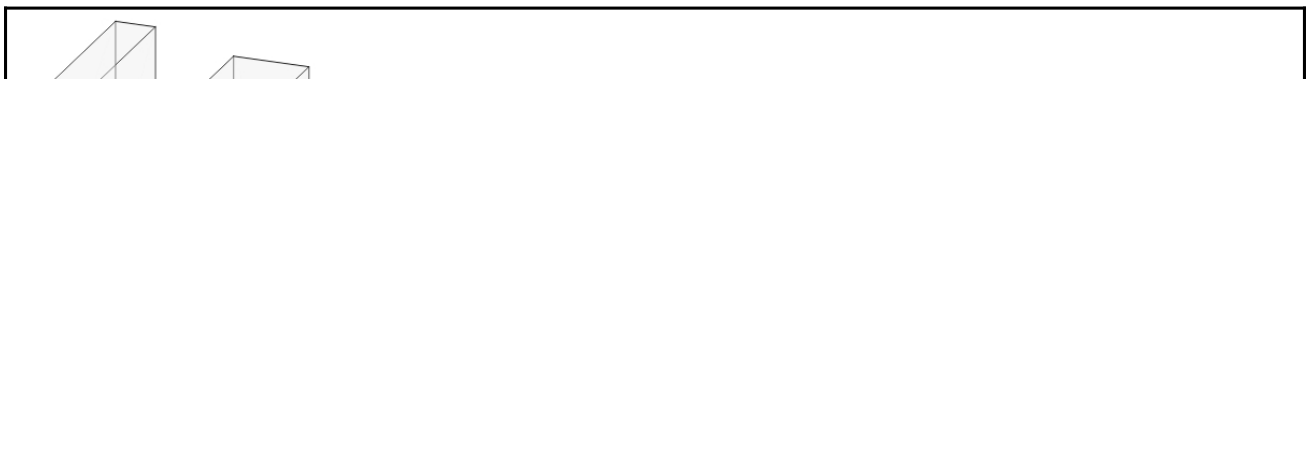

As we can see, there are four convolutional layers and two fully connected layers in the model. After each convolutional layer, there is a pooling layer. The pooling layers are not shown in the preceding diagram. The convolutional layers process the input image and extract a feature vector, which is fed to the fully connected layers. There is an output layer for the binary classification.

### Implementation

Dumb baselines:

In [ ]:
# get the labels of validation dataset
y_val = [y for _,y in val_ds]

# function to calculate classification accuracy
def accuracy(labels, out):
		return np.sum(out==labels)/float(len(labels))

# dumb baseline for all-zero predictions
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)
>> accuracy all zero prediction: 0.60

# dumb baseline for all-ones predictions
acc_all_ones = accuracy(y_val, np.ones_like(y_val))
print("accuracy all one prediction: %.2f" %acc_all_ones)
>> accuracy all ones prediction: 0.40

# dumb baseline for random predictions
acc_random = accuracy(y_val, np.random.randint(2,size=len(y_val)))
print("accuracy random prediction: %.2f" %acc_random)
>> accuracy random prediction: 0.50

Implement the CNN model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the Net class
class Net(nn.Module):
		def __init__(self, params):
				super(Net, self).__init__()
				C_in, H_in, W_in = params["input_shape"]
				init_f = params["initial_filters"]
				num_fc1 = params["num_fc1"]
				num_classes = params["num_classes"]
				self.dropout_rate = params["dropout_rate"]

				self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
				h,w = findConv2dOutShape(H_in,W_in,self.conv1)
				self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
				h,w = findConv2dOutShape(h,w,self.conv2)
				self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
				h,w = findConv2dOutShape(h,w,self.conv3)
				self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
				h,w = findConv2dOutShape(h,w,self.conv4)
				# compute the flatten size
				self.num_flatten = h*w*8*init_f
				self.fc1 = nn.Linear(self.num_flatten, num_fc1)
				self.fc2 = nn.Linear(num_fc1, num_classes)

		def forward(self, x):
				x = F.relu(self.conv1(x))
				x = F.max_pool2d(x, 2, 2)
				x = F.relu(self.conv2(x))
				x = F.max_pool2d(x, 2, 2)
				x = F.relu(self.conv3(x))
				x = F.max_pool2d(x, 2, 2)
				x = F.relu(self.conv4(x))
				x = F.max_pool2d(x, 2, 2)
				x = x.view(-1, self.num_flatten)
				x = F.relu(self.fc1(x))
				x = F.dropout(x, self.dropout_rate, training = self.training)
				x = self.fc2(x)
				return F.log_softmax(x, dim=1)

Construct an object of the Net class:

In [ ]:
# dict to define model parameters
params_model={"input_shape": (3,96,96),
							"initial_filters": 8,
							"num_fc1": 100,
							"dropout_rate": 0.25,
							"num_classes": 2}

# create model
cnn_model = Net(params_model)

# move model to cuda/gpu device
if torch.cuda.is_available():
		device = torch.device("cuda")
		cnn_model = cnn_model.to(device)

# print the model
print(cnn_model)

# get a summary of the model
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96), device=device.type)

Define the loss and optimizer function:

In [ ]:
# loss function
loss_func = nn.NLLLoss(reduction="sum")

# optimizer function
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

# Next, we will define a learning scheduler using the ReduceLROnPlateau method:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20, verbose=1)

### Training

So far, we've created the datasets, built the model, and defined the loss function and optimizer. Now, we'll implement the training and validation scripts. The training and validation scripts can be long and repetitive. For better code readability and to avoid code repetition, I have already built few helper functions (see Appendix).

In [ ]:
def train_val(model, params):
		# extract model parameters
		num_epochs=params["num_epochs"]
		loss_func=params["loss_func"]
		opt=params["optimizer"]
		train_dl=params["train_dl"]
		val_dl=params["val_dl"]
		sanity_check=params["sanity_check"]
		lr_scheduler=params["lr_scheduler"]
		path2weights=params["path2weights"]

		# define two dictionaries to keep a history of the loss and accuracy values:
		# history of loss values in each epoch
		loss_history={"train": [], "val": []}
		# history of metric values in each epoch
		metric_history={"train": [], "val": []}

		# we will create a copy of state_dict:
		# a deep copy of weights for the best performing model
		best_model_wts = copy.deepcopy(model.state_dict())

		# Then, we will initialize the best loss to an infinite value:
		# initialize best loss to a large value
		best_loss=float('inf')

		# Next, we will define a loop that will calculate the training loss over an epoch:
		# main loop
		for epoch in range(num_epochs):
				# get current learning rate
				current_lr=get_lr(opt)
				print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
				# train model on training dataset
				model.train()
				train_loss, train_metric = loss_epoch(model,loss_func,train_dl,sanity_check,opt)
				# collect loss and metric for training dataset
				loss_history["train"].append(train_loss)
				metric_history["train"].append(train_metric)
				# Then, we will evaluate the model on the validation dataset:
				# evaluate model on validation dataset
				model.eval()
				with torch.no_grad():
						val_loss, val_metric = loss_epoch(model,loss_func,val_dl,sanity_check)
				# collect loss and metric for validation dataset
				loss_history["val"].append(val_loss)
				metric_history["val"].append(val_metric)
				# Next, we will store the best weights:
				# store best model
				if val_loss < best_loss:
						best_loss = val_loss
						best_model_wts = copy.deepcopy(model.state_dict())
				# store weights into a local file
				torch.save(model.state_dict(), path2weights)
				print("Copied best model weights!")
				
				# Then, we will update the learning rate if needed:
				# learning rate schedule
				lr_scheduler.step(val_loss)
				if current_lr != get_lr(opt):
						print("Loading best model weights!")
						model.load_state_dict(best_model_wts)

		# Finally, we will print the loss and accuracy values and return the trained model:
		print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
		print("-"*10)

		# load best model weights
		model.load_state_dict(best_model_wts)
		return model, loss_history, metric_history

Run the sanity check

In [ ]:
# Define the objects for the optimization, loss, and learning rate schedule:
import copy
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

# Define the training parameters and call the train_val helper function:
params_train={"num_epochs": 100,
							"optimizer": opt,
							 "loss_func": loss_func,
							 "train_dl": train_dl,
							 "val_dl": val_dl,
							 "sanity_check": True,
							 "lr_scheduler": lr_scheduler,
							 "path2weights": "./models/weights.pt"}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

>> Output
Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.000129, dev loss: 0.001024, accuracy: 0.05
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 0.000125, dev loss: 0.001021, accuracy: 0.05

Plot the progress

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]
# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid()
plt.show()

By doing this, we've made sure that all the elements are implemented correctly. Let's set the flag to sanity_check: False and run the code. The training will start and we will see its progress. Once you get a baseline performance using your first model, you can start tuning hyperparameters. Hyperparameter tuning is a technique that's used to improve model performance. An effective way of doing this is by using a random search. We defined the hyperparameters as variables so that we can easily play with them. Try different values for the hyperparameters and see how the model's performance is affected. As an example, try increasing the number of CNN filters by setting initial_filters = 16 and retraining the model.

### Evaluation

In [ ]:
# use the helper function to evaluate the model on the validation dataset
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device, sanity_check=False)
print(y_out.shape,y_gt.shape)

# calculate the accuracy of the model
from sklearn.metrics import accuracy_score
# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)
# compute accuracy
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

# Let's also measure the inference time on the CPU device
device_cpu = torch.device("cpu")
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device_cpu, sanity_check=False)
print(y_out.shape,y_gt.shape

### Inference

In [ ]:
# First, let's load test_labels.csv and print out its head:
path2csv="./data/test_labels.csv"
labels_df=pd.read_csv(path2csv)
labels_df.head()

# Create a dataset object for the test dataset:
histo_test = histoCancerDataset(data_path, val_transformer,data_type="test")
print(len(histo_test))

# Deploy the model on the test dataset:
y_test_out,_ = deploy_model(cnn_model, histo_test, device, sanity_check=False)
y_test_pred = np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)

# Display a few images and predictions:
grid_size=4
rnd_inds = np.random.randint(0,len(histo_test),grid_size)
print("image indices:",rnd_inds)

x_grid_test=[histo_test[i][0] for i in range(grid_size)]
y_grid_test=[y_test_pred[i] for i in range(grid_size)]
x_grid_test=utils.make_grid(x_grid_test, nrow=4, padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test,y_grid_test)

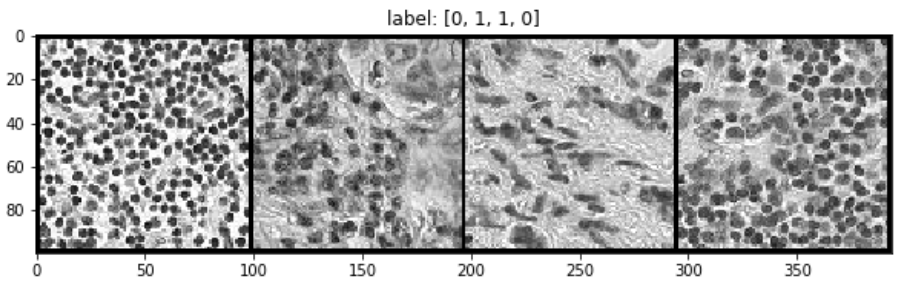

### Appendix
Helper function

In [ ]:
# First, let's develop a helper function to count the number of correct predictions per data batch:
def metrics_batch(output, target):
		# get output class
		pred = output.argmax(dim=1, keepdim=True)
		# compare output class with target class
		corrects=pred.eq(target.view_as(pred)).sum().item()
		return corrects

# Then, we will develop a helper function to compute the loss value per batch of data:
def loss_batch(loss_func, output, target, opt=None):
		loss = loss_func(output, target)
		with torch.no_grad():
		metric_b = metrics_batch(output,target)
		if opt is not None:
		opt.zero_grad()
		loss.backward()
		opt.step()
		return loss.item(), metric_b

''' Next, we develop a helper function to compute the loss value and 
the performance metric for the entire dataset, also called an epoch.'''

# Define the loss_epoch function:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
		running_loss=0.0
		running_metric=0.0
		len_data=len(dataset_dl.dataset)
		for xb, yb in dataset_dl:
				# move batch to device
				xb=xb.to(device)
				yb=yb.to(device)
				# get model output
				output=model(xb)
				# get loss per batch
				loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
				# update running loss
				running_loss+=loss_b
				# update running metric
				if metric_b is not None:
				running_metric+=metric_b
				# break the loop in case of sanity check
				if sanity_check is True:
				break
		# The function ends with the following:
		# average loss value
		loss=running_loss/float(len_data)
		# average metric value
		metric=running_metric/float(len_data)
		return loss, metric

''' helper function to deploy the model on a dataset'''
# Define the deploy_model function:
def deploy_model(model,dataset,device, num_classes=2,sanity_check=False):
		len_data=len(dataset)
		# initialize output tensor on CPU: due to GPU memory limits
		y_out=torch.zeros(len_data,num_classes)
		# initialize ground truth on CPU: due to GPU memory limits
		y_gt=np.zeros((len_data),dtype="uint8")
		# move model to device
		model=model.to(device)
		elapsed_times=[]
		with torch.no_grad():
				for i in range(len_data):
						x,y=dataset[i]
						y_gt[i]=y
						start=time.time()
						y_out[i]=model(x.unsqueeze(0).to(device))
						elapsed=time.time()-start
						elapsed_times.append(elapsed)
						if sanity_check is True:
								break
		inference_time=np.mean(elapsed_times)*1000
		print("average inference time per image on %s: %.2f ms " %(device,inference_time))
		return y_out.numpy(),y_gt